# Assignment 3: Regression and classification

Authors: Kevin To and Filip Cederqvist

Work load: ...

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv("./datasets/data_assignment3.csv")
display(df)

,residue name,position,chain,phi,psi
0,LYS,10,A,-149.312855,142.657714
1,PRO,11,A,-44.283210,136.002076
2,LYS,12,A,-119.972621,-168.705263
3,LEU,13,A,-135.317212,137.143523
4,LEU,14,A,-104.851467,95.928520
...,...,...,...,...,...
29364,GLY,374,B,-147.749557,155.223562
29365,GLN,375,B,-117.428541,133.019506
29366,ILE,376,B,-113.586448,112.091970
29367,ASN,377,B,-100.668779,-12.102821


## Part 1: Show the distribution of phi and psi combinations using:

#### a) Scatter plot

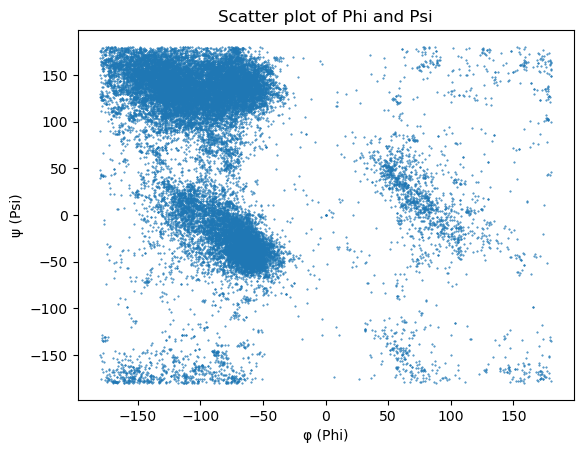

In [2]:
# Removing NaN values in Phi and Psi columns
df.dropna()

phi_values = df["phi"]
psi_values = df["psi"]

plt.scatter(phi_values, psi_values, s=0.2)
plt.xlabel('φ (Phi)')
plt.ylabel('ψ (Psi)')

plt.title('Scatter plot of Phi and Psi')
plt.show()

#### b) 2D histogram

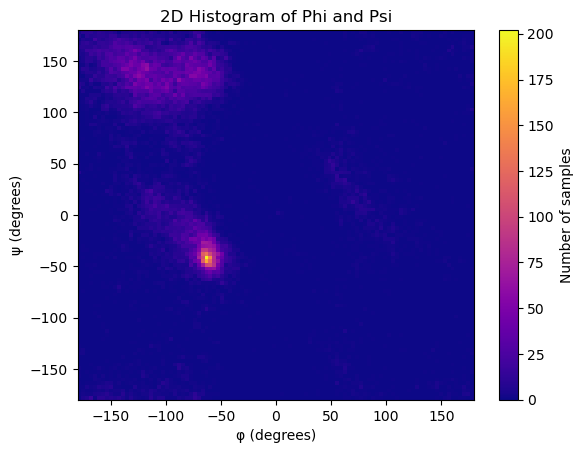

In [3]:
# 2D Histogram

plt.hist2d(phi_values, psi_values, bins=100, cmap="plasma")
plt.xlabel('φ (degrees)')
plt.ylabel('ψ (degrees)')

cb = plt.colorbar()
cb.set_label('Number of samples')

plt.title('2D Histogram of Phi and Psi')
plt.show()

#### 1c) Transform the data to better visual the Ramachandran plot

Since the data wraps around the top and bottom edge, as well as the right to left edge, we can better visualise the data if transform the data into a cylindric projection. This will unwrap the plot into a flat and rectangular plot instead.

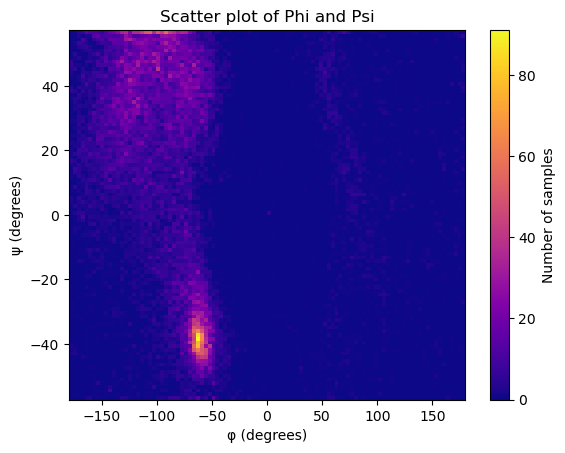

In [4]:
def transform_ramachandran(phi_list, psi_list):
    # Convert phi and psi angles to radians
    phi_list = np.deg2rad(phi_list)
    psi_list = np.deg2rad(psi_list)
   
    # Convert phi and psi angles to Cartesian coordinates
    x = np.cos(phi_list)
    y = np.sin(phi_list)
    z = np.sin(psi_list)
    
    # Project Cartesian coordinates onto cylinder
    u = np.arctan2(y, x)
    v = z
    
    return np.rad2deg(u), np.rad2deg(v)

tf_phi, tf_psi = transform_ramachandran(phi_values, psi_values)

plt.hist2d(tf_phi, tf_psi, bins=100, cmap="plasma")
plt.xlabel('φ (degrees)')
plt.ylabel('ψ (degrees)')

cb = plt.colorbar()
cb.set_label('Number of samples')

plt.title('Scatter plot of Phi and Psi')
plt.show()

## Part 2: Use the K-means clustering method to cluster the phi and psi angle combinations in the data file.

#### a) Use an appropriate method to evaluate which value of K that gives the best clustering.

Text(0.5, 0.98, 'Clustered scatterplots with k ranging 1 through 10')

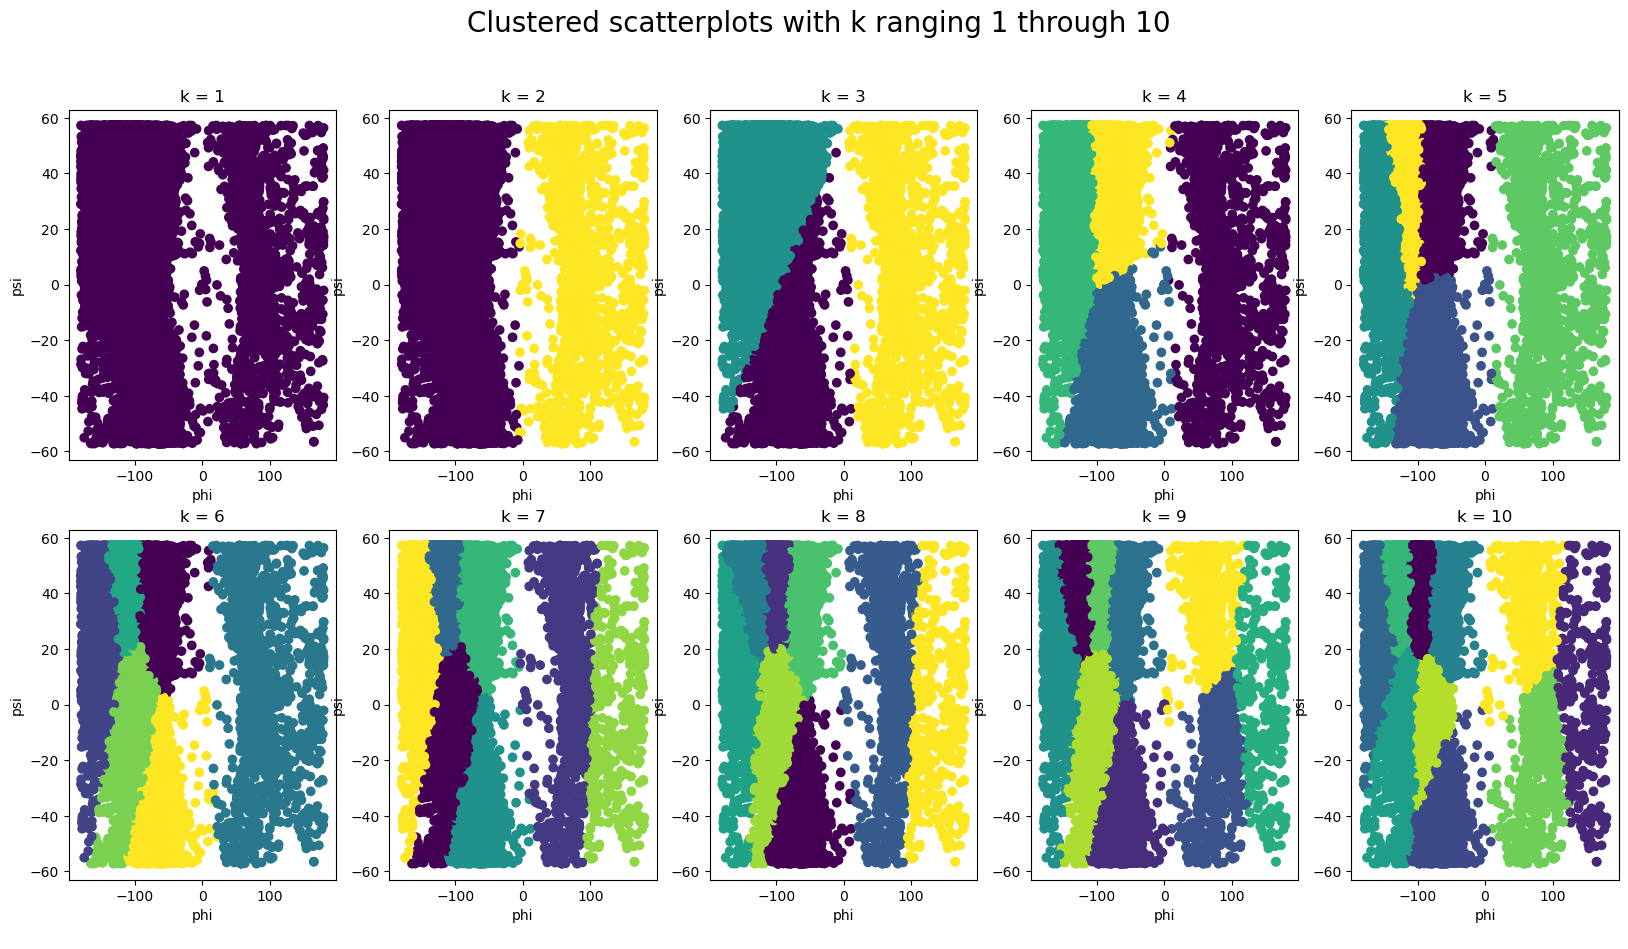

In [5]:
from sklearn.cluster import KMeans
df["phi"] = tf_phi
df["psi"] = tf_psi

ks = range(1, 11)
diameter = []

fig, axs = plt.subplots(2, 5, figsize=(20, 10))

y, x = 0, 0
for k in ks:
    model = KMeans(n_clusters=k)
    model.fit(df[["phi", "psi"]])

    y_pred = model.predict(df[["phi", "psi"]])
    diameter.append(model.inertia_)

    axs[y][x].scatter(x=df['phi'],y=df['psi'],c=y_pred)
    axs[y][x].set_xlabel('phi\n')
    axs[y][x].set_ylabel('psi')
    axs[y][x].set_title(f'k = {k}')

    x += 1
    if x == 5:
        y += 1
        x = 0

fig.suptitle('Clustered scatterplots with k ranging 1 through 10', fontsize=20)

When plotting the clusters, it is evident that k should be between either k=3 or k=4 as the distances between two points of the same color is small. It is difficult to determined what the optimal k is visually. Hence, we will use the Elbow method as well.

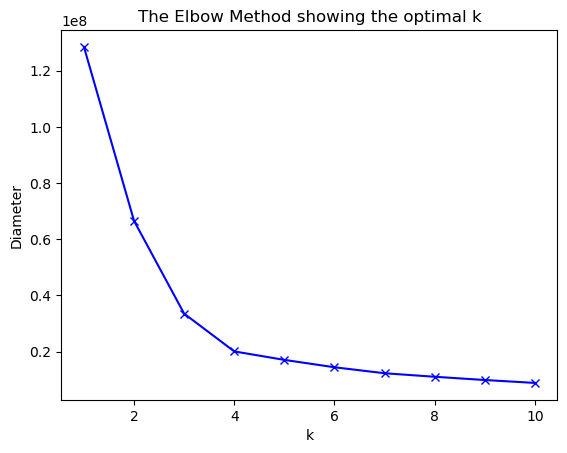

In [6]:
# Plot the elbow curve

plt.plot(ks, diameter, 'bx-')
plt.xlabel('k')
plt.ylabel('Diameter')
plt.title('The Elbow Method showing the optimal k')
plt.show()


Answer: From the elbow curve, we can see that the elbow is at **k = 3** since the distance of the diameter makes the most decline between k=2 and k=3. From k=4 and onwards, the decline is almost stagnant.

#### b) Do the clusters found in part (a) seem reasonable?

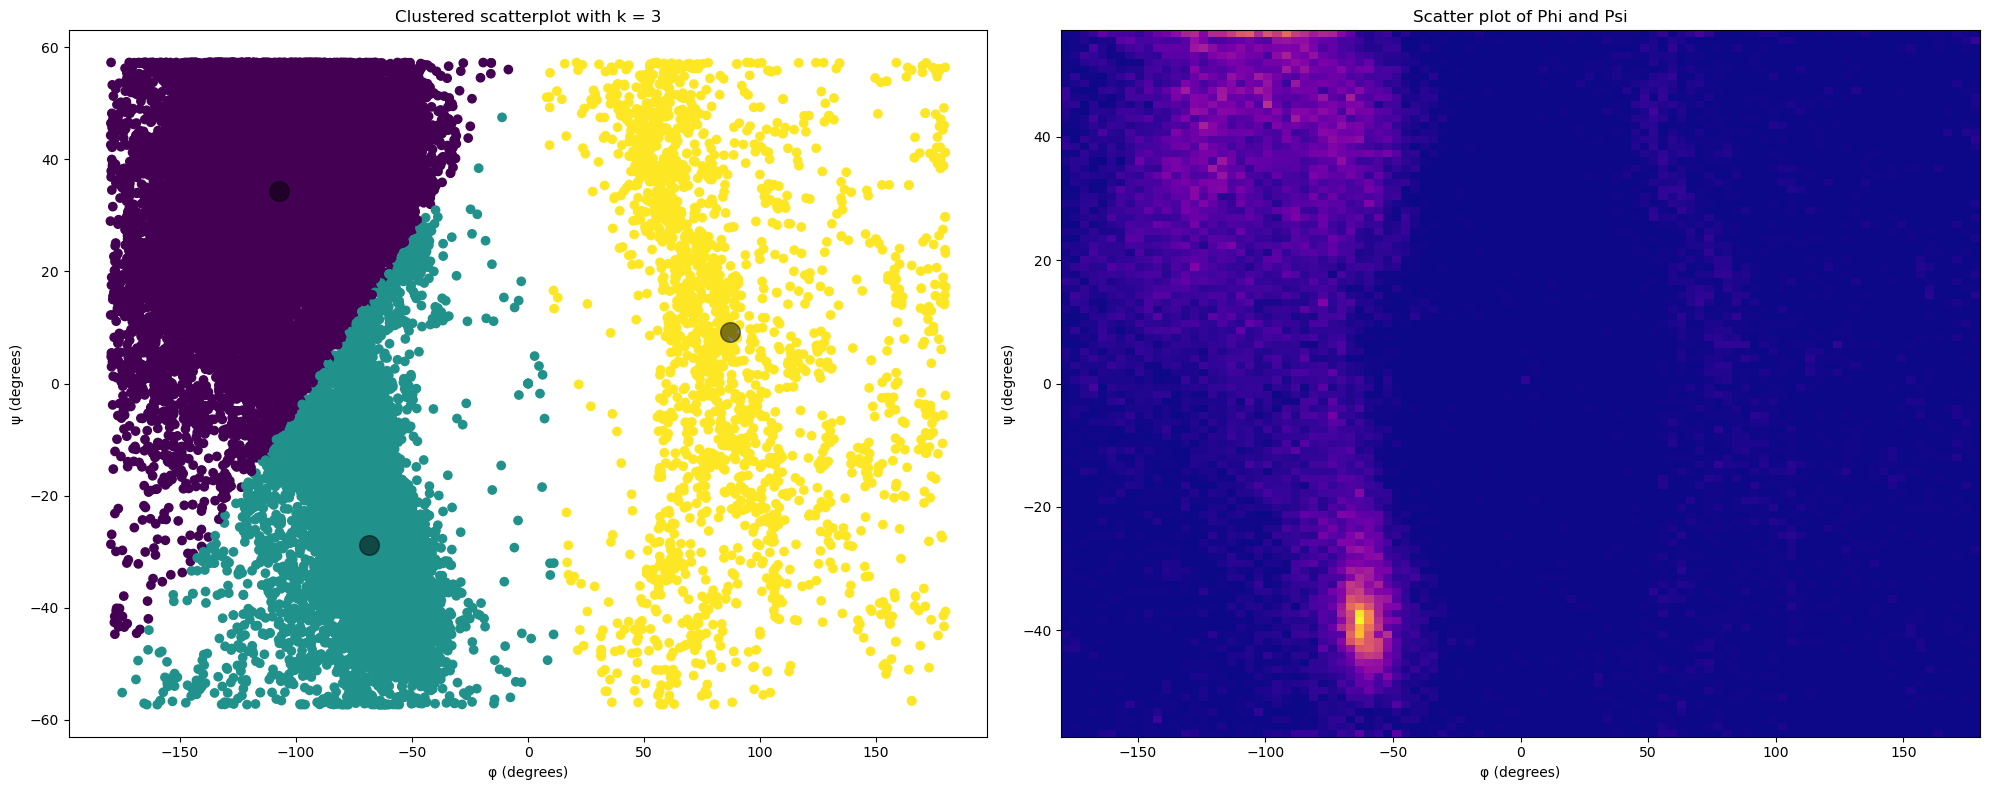

In [7]:
k = 3
model = KMeans(n_clusters=k)
model.fit(df[["phi", "psi"]])

y_pred = model.predict(df[["phi", "psi"]])

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))
ax1.scatter(x=df['phi'],y=df['psi'],c=y_pred)
ax1.set_xlabel('φ (degrees)')
ax1.set_ylabel('ψ (degrees)')
ax1.set_title("Clustered scatterplot with k = 3")

centers = model.cluster_centers_
ax1.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

ax2.hist2d(tf_phi, tf_psi, bins=100, cmap="plasma")
ax2.set_xlabel('φ (degrees)')
ax2.set_ylabel('ψ (degrees)')
ax2.set_title('Scatter plot of Phi and Psi')

plt.tight_layout()


Answer: The clusters recieved from using k = 3 seems reasonable, especially when you compare it the heatmap from part 1. The clusters are at simliar locations as the most intensive place on the heatmap.

## Part 3: Use the DBSCAN method to cluster the phi and psi angle combinations in the data file

### 3a


i, By analyzing the heat map and scatter chart for the data we could estimate the minimum number of samples in the neighborhood for a point to be considered a core point. However, the goal of the clustering or what the clustering would be used for is not clear which makes deciding  the parameters based on domain knowledge difficult. Never the less we chose to set the min_sample to 100 after a bit of trial and error.

ii, To determine the epsilon we used the NearestNeighbor distance as shown below. The "elbow" indicated that epsilon would be around 2. After some tests we found that 4 gave the best result. 

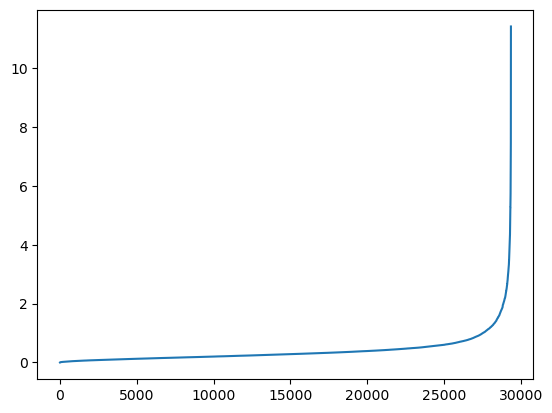

In [8]:
from sklearn.neighbors import NearestNeighbors

neighbors = NearestNeighbors(n_neighbors=100)
neighbors_fit = neighbors.fit(df[['phi', 'psi']])
distances, indices = neighbors_fit.kneighbors(df[[ 'phi', 'psi']]) 
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

### 3b

DBSCAN(eps=4, min_samples=100)
Estimated number of clusters: 2
Estimated number of noise points: 7134


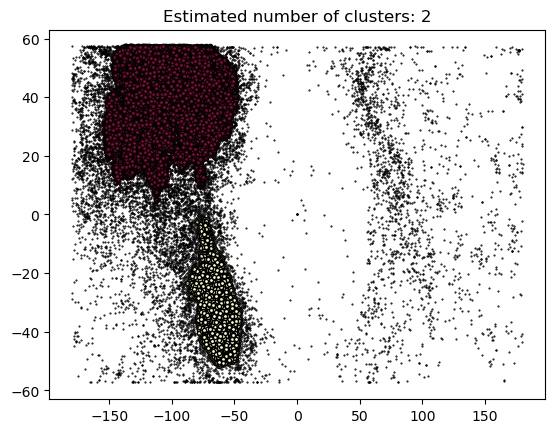

In [9]:
from sklearn.cluster import DBSCAN

#Cluster with DBSCAN
db = DBSCAN(eps=4, min_samples=100).fit(df[['phi', 'psi']])
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

# print results
print(db)
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

#plot results
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = df[[ 'phi', 'psi']].values[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=3)

    xy = df[[ 'phi', 'psi']].values[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=0.5)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()


### 3c

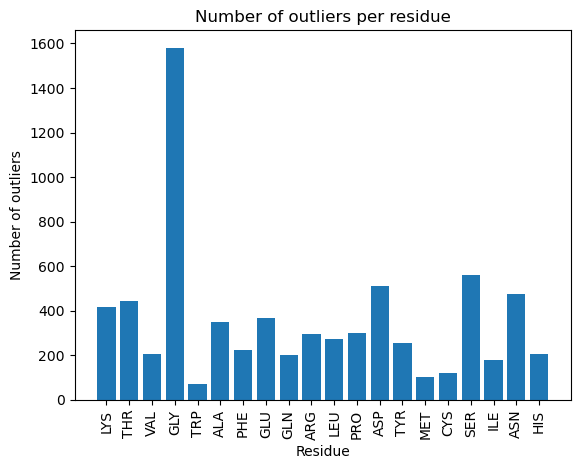

In [10]:
#Add labels to dataframe
new_df = df.copy()
new_df.insert(2,'labels', labels, True)
unique_residues = list(set(new_df['residue name'].values))
#create a list of the number of outliers per residue
number_of_outliers = []
for i in unique_residues:
    number_of_outliers.append(new_df[(new_df['residue name'] == i) & (new_df['labels'] == -1)].shape[0])

#plot the number of outliers per residue
plt.bar(unique_residues, number_of_outliers)
plt.title('Number of outliers per residue')
plt.xlabel('Residue')
plt.ylabel('Number of outliers')
plt.xticks(rotation=90)
plt.show()

There where 7134 noise points and almost 1600 of them where from the GLY residue


### 3d

The main difference between the clustering with the K-mean and DBSACN is that DBSCAN classified some of the points as noise. The result of this was that only two clusters were detected with the DBSCAN instead of 3 with K-mean. Only the two clusters with higher density were detected.  

## 4, Cluster with stratification by risidual type

,residue name,position,chain,phi,psi
0,PRO,11,A,-44.283210,39.799499
1,PRO,27,A,-49.944645,-25.016995
2,PRO,79,A,-76.452014,56.773080
3,PRO,121,A,-53.054020,-26.238610
4,PRO,134,A,-66.751364,57.149163
...,...,...,...,...,...
1591,PRO,288,B,-54.565923,-38.443337
1592,PRO,349,B,-66.803083,39.613086
1593,PRO,350,B,-59.612140,19.550835
1594,PRO,357,B,-48.679835,40.366679


(1400.0, 1600.0, 0.0, 20.0)

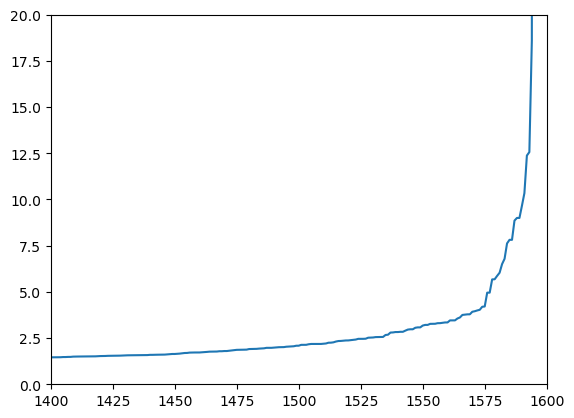

In [16]:
# Creating new dataframe with only PRO residues
PRO_df = df[df['residue name'] == 'PRO']
PRO_df = PRO_df.reset_index(drop=True)
display(PRO_df)

#find epsilon value
neighbors = NearestNeighbors(n_neighbors=100)
neighbors_fit = neighbors.fit(PRO_df[['phi', 'psi']])
distances, indices = neighbors_fit.kneighbors(PRO_df[[ 'phi', 'psi']])
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)
plt.axis([1400, 1600, 0, 20])



DBSCAN(eps=10, min_samples=100)
Estimated number of clusters: 2
Estimated number of noise points: 131


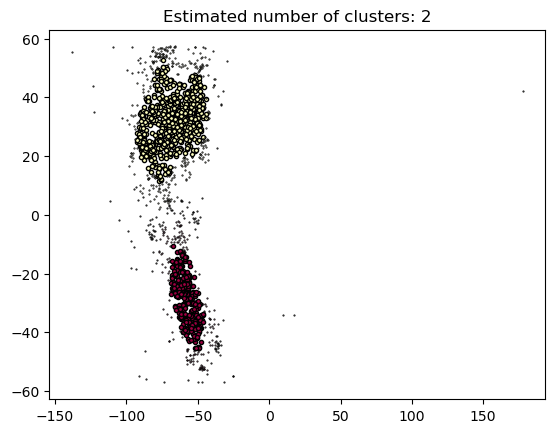

In [12]:
#Cluster with DBSCAN
db = DBSCAN(eps=10, min_samples=100).fit(PRO_df[["phi", "psi"]])
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

# print results
print(db)
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

#plot results
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = PRO_df[["phi", "psi"]].values[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=3)

    xy = PRO_df[["phi", "psi"]].values[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=0.5)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()


The main conclusions that can be drawn from this is that the percentage of noise was dramatically reduced but the clusters was basically the same. It could be concluded that the PRO residue to a greater extent conforms to the main clusters. 